## tensorflow tutorials RNN を使ったテキスト分類

tensorflowが2.0になってチュートリアルも新しくなりました。勉強がてら、すべてのチュートリアルを自分の環境で行ってみたいと思います。コードはチュートリアルのコピーです。その中で気づいた部分や、注意すべき部分がこの記事の付加価値です。

- https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=ja

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6032


In [2]:
!python -V

Python 3.8.5


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

print('tf version     : ', tf.__version__)
print('keras version  : ', keras.__version__)
print('numpy version  : ', np.__version__)
print('pandas version : ', pd.__version__)
print('matlib version : ', matplotlib.__version__)

tf version     :  2.3.1
keras version  :  2.4.0
numpy version  :  1.18.5
pandas version :  1.1.3
matlib version :  3.3.2


## ヘルパー関数の作成
結果を描画するための関数

In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 入力パイプラインの設定

IMDB映画レビューのデータセットは二値分類のデータセット。PositiveかNegativeの二択。TFDSを利用してダウンロード。

In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

エンコードを含、任意の文字列を可逆的にエンコードする。

In [6]:
encoder = info.features['text'].encoder

In [7]:
'Vocabulary size: {}'.format(encoder.vocab_size)

'Vocabulary size: 8185'

In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## 訓練用データの準備

エンコード済み文字列をバッチ化する。padded_batchメソッドを利用して、バッチ中の一番長い文字列の長さにゼロパッディングする。

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

## モデルの作成

Embeddingレイヤーの作成。単語一つに対して、一つのベクトルを収容する。呼び出しを受けると、Embeddingレイヤーは単語のインデックスのシーケンスをベクトルのシーケンスに変換する。

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(encoder.vocab_size, 64),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## モデルの訓練

In [15]:
epochs = 10 # default

history = model.fit(train_dataset, epochs=epochs,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 319s 816ms/step - loss: 0.6541 - accuracy: 0.5618 - val_loss: 0.5182 - val_accuracy: 0.7250
Epoch 2/10
391/391 [==============================] - 319s 816ms/step - loss: 0.3670 - accuracy: 0.8366 - val_loss: 0.3457 - val_accuracy: 0.8641
Epoch 3/10
391/391 [==============================] - 319s 817ms/step - loss: 0.2564 - accuracy: 0.8997 - val_loss: 0.3444 - val_accuracy: 0.8432
Epoch 4/10
391/391 [==============================] - 321s 822ms/step - loss: 0.2129 - accuracy: 0.9216 - val_loss: 0.3513 - val_accuracy: 0.8719
Epoch 5/10
391/391 [==============================] - 319s 816ms/step - loss: 0.1965 - accuracy: 0.9281 - val_loss: 0.3426 - val_accuracy: 0.8672
Epoch 6/10
391/391 [==============================] - 338s 864ms/step - loss: 0.1666 - accuracy: 0.9424 - val_loss: 0.3506 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 318s 813ms/step - loss: 0.1492 - accuracy: 0.9491 - val_loss: 0.4276 -

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 73s 186ms/step - loss: 0.4424 - accuracy: 0.8499
Test Loss: 0.44243761897087097
Test Accuracy: 0.8498799800872803


In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.25093532]]


In [20]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.1853367]]


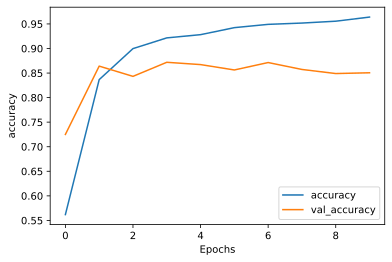

In [21]:
plot_graphs(history, 'accuracy')

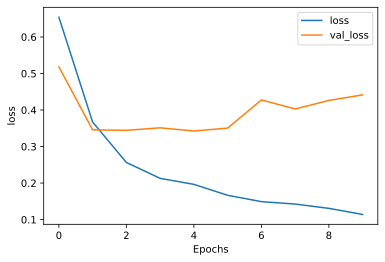

In [22]:
plot_graphs(history, 'loss')

## 2つ以上の LSTM レイヤー

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
epochs = 10 # default

history = model.fit(train_dataset, epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 650s 2s/step - loss: 0.6452 - accuracy: 0.5642 - val_loss: 0.4430 - val_accuracy: 0.8010
Epoch 2/10
391/391 [==============================] - 645s 2s/step - loss: 0.3507 - accuracy: 0.8590 - val_loss: 0.3421 - val_accuracy: 0.8641
Epoch 3/10
391/391 [==============================] - 650s 2s/step - loss: 0.2537 - accuracy: 0.9091 - val_loss: 0.3423 - val_accuracy: 0.8667
Epoch 4/10
391/391 [==============================] - 623s 2s/step - loss: 0.2121 - accuracy: 0.9259 - val_loss: 0.3464 - val_accuracy: 0.8724
Epoch 5/10
391/391 [==============================] - 599s 2s/step - loss: 0.1717 - accuracy: 0.9447 - val_loss: 0.3799 - val_accuracy: 0.8667
Epoch 6/10
391/391 [==============================] - 635s 2s/step - loss: 0.1467 - accuracy: 0.9562 - val_loss: 0.4317 - val_accuracy: 0.8417
Epoch 7/10
391/391 [==============================] - 624s 2s/step - loss: 0.1295 - accuracy: 0.9630 - val_loss: 0.4347 - val_accuracy: 0.8542

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 145s 371ms/step - loss: 0.5422 - accuracy: 0.8408
Test Loss: 0.5422017574310303
Test Accuracy: 0.8408399820327759


In [27]:
# パディングなしのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.7144954]]


In [28]:
# パディングありのサンプルテキストの推論

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.1235375]]


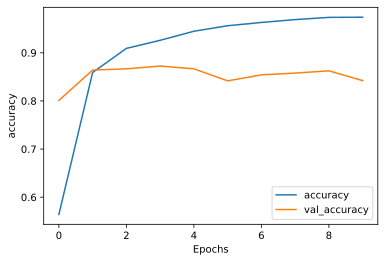

In [29]:
plot_graphs(history, 'accuracy')

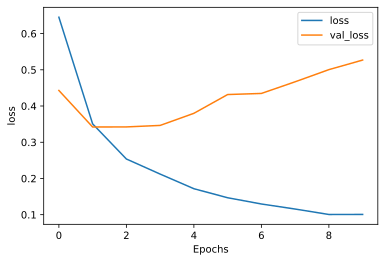

In [30]:
plot_graphs(history, 'loss')

過学習が起きていますので、何らかの正規化やDropOut層の追加が必要でしょうか。